In [50]:
%config IPCompleter.greedy=True
%matplotlib inline
import string
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Challenge: Feedback analysis

### Overview of model:

My model works at about 65% accross datasets, which is just a bit better than always guessing `is_positive`, which would yield 51% accuracy.

At this point, my feature engineering is simply listing words with strong positive or negative associations. I didn't spent a ton of time largely because I know this is where NLP really shines.

In [2]:
def print_confusion_matrix(target, y_pred):
    cm = confusion_matrix(target, y_pred)
    positive_percentage = round(cm[1][1]/target.sum(), 2)
    negative_percentage = round(cm[0][0]/((target == False).sum()), 2)
    print(f'\nTrue Positives: {cm[1][1]} ({positive_percentage}) \nTrue Negatives: {cm[0][0]} ({negative_percentage}) \nFalse Positives: {cm[0][1]} \nFalse Negatives: {cm[1][0]}')
    

In [53]:
def remove_punct(my_str):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    return my_str.translate(table)

def load_and_prep_data(file, keywords, show_chart=True):
    print(f'\n{file}')
    df = pd.read_csv(f'data/{file}.txt', delimiter= '\t', header=None)
    df.columns = ['sentence', 'is_positive']
    df['is_positive'] = (df['is_positive'] == 1)
    df.sentence = df.sentence.apply(remove_punct)

    for key in keywords:
        # Add spaces around the key so that we're getting the word, not just pattern matching.
        df[str(key)] = df.sentence.str.contains(
            str(key),
            case=False
        )
    if show_chart:
        sns.heatmap(df.corr())
        plt.show()
    return df

In [18]:
def create_all_training_datasets(files, keywords):
    training_datasets = {}
    for file in files:
        training_datasets[file] = load_and_prep_data(file, keywords, show_chart=True)
    return training_datasets

In [19]:
def create_and_test_model(df, existing_model=None):
    data = df[keywords]
    target = df['is_positive']
    
    if existing_model:
        bnb = existing_model
    else:
        # Our data is binary / boolean, so we're importing the Bernoulli classifier.
        from sklearn.naive_bayes import BernoulliNB
        bnb = BernoulliNB()

        # Fit our model to the data.
        bnb.fit(data, target)

    # Classify, storing the result in a new variable.
    y_pred = bnb.predict(data)

    # Display our results.
    correct = (target == y_pred).sum()
    total = data.shape[0]
    positive_cases = df['is_positive'].sum()
    print(f'Positive cases: {positive_cases}/{total} ({100.0*positive_cases/total})')
    print(f'Correctly labeled {correct}/{total} points: {100.0*correct/total}%')
    print_confusion_matrix(target, y_pred)
    
    return bnb

In [20]:
IMDB = 'imdb'
AMAZON = 'amazon'
YELP = 'yelp'
files = [IMDB, AMAZON, YELP]

## Keyword features

In [101]:
# Features:
amazon_pos = ['satisfied', 'would recommend', 'highly recommend']
amazon_neg = ['do not', 'joke', 'low', 'unfortunate', 'mad', 'sad', 'crap']
yelp_pos = ['enjoy', 'delicious', 'nice', 'soon', 'perfect', 'tasty']
yelp_neg = ['sick', 'sad', 'dirty', 'piss', 'expensive', 'rude']
positive_keywords = ['good', 'great', 'love', 'enjoy', 'best', 'incredible', 'wonderful', 'favorite', 'cool',] + amazon_pos + yelp_pos
negative_keywords = ['bad', 'terrible', 'aweful', 'hate', 'worst', 'little', 'lack', 'waste', 'odd',] + amazon_neg + yelp_neg
keywords = positive_keywords + negative_keywords

In [100]:
training_datasets[YELP][['sentence', 'is_positive']].sort_values('is_positive').head()

,sentence,is_positive
999,Then as if I hadnt wasted enough of my life th...,False
784,The chains which Im no fan of beat this place ...,False
388,This is a disgrace,False
387,This place deserves one star and 90 has to do ...,False
786,We will not be coming back,False


## Load all training datasets with keywords as features.


imdb


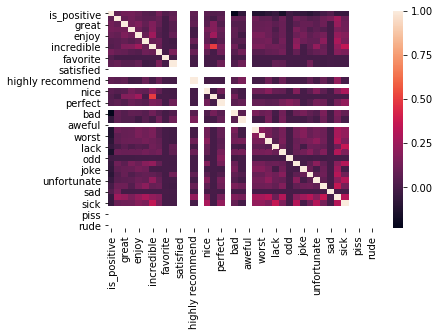


amazon


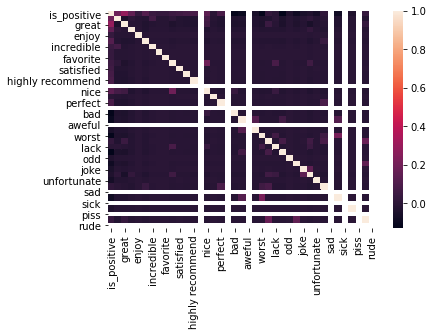


yelp


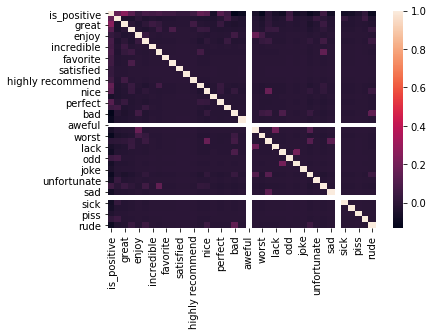

In [102]:
training_datasets = create_all_training_datasets(files, keywords)

## IMDB

In [103]:
imdb_model = create_and_test_model(training_datasets[IMDB])

Positive cases: 386/748 (51.60427807486631)
Correctly labeled 487/748 points: 65.10695187165776%

True Positives: 367 (0.95) 
True Negatives: 120 (0.33) 
False Positives: 242 
False Negatives: 19


## Test IMDB model on other datasets:

In [104]:
for file in files:
    print('\n\n', file)
    create_and_test_model(training_datasets[file], existing_model=imdb_model)



 imdb
Positive cases: 386/748 (51.60427807486631)
Correctly labeled 487/748 points: 65.10695187165776%

True Positives: 367 (0.95) 
True Negatives: 120 (0.33) 
False Positives: 242 
False Negatives: 19


 amazon
Positive cases: 500/1000 (50.0)
Correctly labeled 579/1000 points: 57.9%

True Positives: 486 (0.97) 
True Negatives: 93 (0.19) 
False Positives: 407 
False Negatives: 14


 yelp
Positive cases: 500/1000 (50.0)
Correctly labeled 575/1000 points: 57.5%

True Positives: 491 (0.98) 
True Negatives: 84 (0.17) 
False Positives: 416 
False Negatives: 9


## Status of current IMDB model: *Sensitive, but lacking specificity*

Using the IMDB model fails to identify *negative sentiments* on on all datasets


## ... Amazon and Yelp (trained on themselves) have the opposite problem: *they idenitfy negative cases (specificity), but aren't sensitive to positive cases*

In [71]:
amazon_model = create_and_test_model(training_datasets[AMAZON], existing_model=None)

Positive cases: 500/1000 (50.0)
Correctly labeled 696/1000 points: 69.6%

True Positives: 220 (0.44) 
True Negatives: 476 (0.95) 
False Positives: 24 
False Negatives: 280


In [72]:
yelp_model = create_and_test_model(training_datasets[YELP], existing_model=None)

Positive cases: 500/1000 (50.0)
Correctly labeled 663/1000 points: 66.3%

True Positives: 205 (0.41) 
True Negatives: 458 (0.92) 
False Positives: 42 
False Negatives: 295


# 2.3.5: Iterate Classifier

For five iterations:
- Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. 
- Then go back and iterate by
    - engineering new features, 
    - removing poor features, or 
    - tuning parameters. 

Answer these questions to compare the performance of each:

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?

## Check for Over Fitting via Cross Validation
Cross validation reveals *fairly* stable models, with a few jumps, sometimes as much as 7 or 8 percentage points.

In [74]:
from sklearn.model_selection import cross_val_score
data = training_datasets[YELP]
cross_val_score(yelp_model, data[keywords], data['is_positive'], cv=10)

array([0.6 , 0.69, 0.65, 0.73, 0.65, 0.63, 0.66, 0.65, 0.6 , 0.7 ])

In [75]:
data = training_datasets[AMAZON]
cross_val_score(amazon_model, data[keywords], data['is_positive'], cv=10)

array([0.73, 0.71, 0.79, 0.7 , 0.7 , 0.69, 0.61, 0.64, 0.7 , 0.6 ])

In [78]:
data = training_datasets[IMDB]
cv = cross_val_score(imdb_model, data[keywords], data['is_positive'], cv=10)
np.around(cv, decimals=2)

array([0.66, 0.67, 0.56, 0.65, 0.67, 0.65, 0.64, 0.61, 0.61, 0.69])

## Just counting most common words isn't too informative...

In [93]:
from collections import Counter
def counter(sentences):
    cnt = Counter()
    for sentence in list(sentences):
        for word in sentence.split(' '):
            cnt[word] += 1
    return cnt

In [99]:
counted_words = counter(training_datasets[IMDB].sentence.str.lower())
counted_words.most_common(50)

[('', 1806),
 ('the', 798),
 ('a', 429),
 ('and', 425),
 ('of', 375),
 ('is', 338),
 ('this', 277),
 ('to', 250),
 ('i', 241),
 ('it', 239),
 ('in', 198),
 ('was', 184),
 ('movie', 177),
 ('film', 155),
 ('that', 153),
 ('for', 104),
 ('as', 93),
 ('with', 90),
 ('but', 83),
 ('its', 81),
 ('one', 75),
 ('are', 75),
 ('on', 74),
 ('not', 72),
 ('you', 72),
 ('bad', 66),
 ('very', 65),
 ('just', 63),
 ('so', 59),
 ('all', 57),
 ('good', 56),
 ('an', 53),
 ('at', 52),
 ('about', 50),
 ('be', 50),
 ('have', 48),
 ('by', 48),
 ('like', 47),
 ('from', 46),
 ('there', 44),
 ('time', 42),
 ('acting', 41),
 ('or', 40),
 ('out', 40),
 ('really', 40),
 ('if', 39),
 ('who', 38),
 ('even', 38),
 ('were', 38),
 ('great', 38)]